In [1]:
# 5.2 합성곱 신경망 맛보기

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
# CPU가 돌아갈 수 있는 환경이면 cuda를 사용.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# FashionMNIST를 가져옴. train / test set을  통해.
train_dataset  = torchvision.datasets.FashionMNIST("../chap05/data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_dataset  = torchvision.datasets.FashionMNIST("../chap05/data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()])) 

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../chap05/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../chap05/data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../chap05/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../chap05/data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../chap05/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../chap05/data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../chap05/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../chap05/data/FashionMNIST/raw



In [7]:
# 100개의 단위로 데이터를 가져온다. (분석에 활용된다)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=100)

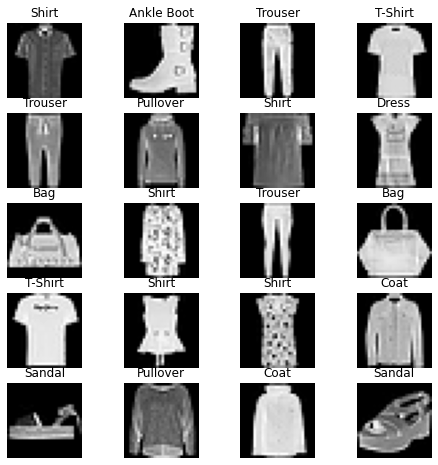

In [8]:
# dictionary로 숫자를 텍스트로 변환
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;

#한번 plotting 해본 결과
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [9]:
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN,self).__init__()
        # Linear -> dropout -> linear -> linear 를 통해 최종 784개의 input feature를 가지고, 10개의 클래스를 나눠 예측
        self.fc1 = nn.Linear(in_features=784,out_features=256)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=256,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=10)

    def forward(self,input_data):
        # input reshape -> Relu function -> dropout -> Relu function -> 최종 activation function
        # 을 통해, forwarding해서 모델을 학습한다.
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [10]:
learning_rate = 0.001;
# 모델을 할당하고, device를 무엇으로 할지를 결정 (cpu or cuda)
model = FashionDNN();
model.to(device)

# 평가하는 기준. (crossentropy)
# 최적화 하는 방향 (기준). Adam optimization
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [11]:
num_epochs = 5
count = 0

# list 형식으로 각각을 append 하여 결과값을 비교하고자 함.
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # image.to 를 해줘야 우리가 원하는 환경에서 변수들이 처리 가능.
        # cuda 환경에서 cpu 에 저장된 input 활용 불가.
        images, labels = images.to(device), labels.to(device)
        
        # autograd를 위해 변수를 지정해둠
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # 결과. forwarding
        outputs = model(train)
        # 결과에 대한 loss 계산.
        loss = criterion(outputs, labels)
        # 그것을 바탕으로 gradient 방향 (개선방향)
        optimizer.zero_grad()
        # backward를 통해 각각의 w 조정
        loss.backward()
        optimizer.step()
        count += 1
        
        # 50개씩 학습될때마다, acuurary, loss 등의 결과값 저장 (즉, test를 한다.)
        if not (count % 50):    
            total = 0
            correct = 0        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)            
                test = Variable(images.view(100, 1, 28, 28))            
                outputs = model(test)            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        # 500개의 기준으로 print
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.5502942800521851, Accuracy: 83.12000274658203%
Iteration: 1000, Loss: 0.41658854484558105, Accuracy: 84.72000122070312%
Iteration: 1500, Loss: 0.33812397718429565, Accuracy: 84.72000122070312%
Iteration: 2000, Loss: 0.43312424421310425, Accuracy: 84.80999755859375%
Iteration: 2500, Loss: 0.2391316294670105, Accuracy: 86.1500015258789%
Iteration: 3000, Loss: 0.2696739435195923, Accuracy: 87.20999908447266%


In [12]:
# 앞단엔 그냥 linear 로 했는데, 이번엔 우린 CNN 처럼 입체적으로 바라보고 학습하겠다.
class FashionCNN(nn.Module):    
    def __init__(self):
        super(FashionCNN, self).__init__() 
        # 1번쨰 layer : 2d conv -> batchnrom -> Relu -> pooling
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )   
        # 2번쨰 layer : 2d conv -> batchnrom -> Relu -> pooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )        
        # 즉, 앞단에는 2d로써 동일한 플로우를 거쳐 크기를 줄임.
        
        # 여기서부터는 그 앞단의 2d를 한줄로 묶고 기존에 알던 방식으로 모델을 짠다.
        # 2d -> full -> dropout -> linear -> linear(final activation)
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        # 기존과 달리 더 복잡해진 앞단의 아케택쳐를 단순히 그냥 지나가는 flow
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)       
        return out

In [13]:
learning_rate = 0.001;
# 모델 할당 및, cuda or cpu 확인
model = FashionCNN();
model.to(device)

# 여기 역시,loss 계산 = crossentropy / 최적화 방법 : adam
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [14]:
num_epochs = 5
count = 0
# list 형식으로 각각을 append 하여 결과값을 비교하고자 함.
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # image.to 를 해줘야 우리가 원하는 환경에서 변수들이 처리 가능.
        # cuda 환경에서 cpu 에 저장된 input 활용 불가.
        images, labels = images.to(device), labels.to(device)
        
        # autograd를 위해 변수를 지정해둠
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # 결과. forwarding
        outputs = model(train)
        # 결과에 대한 loss 계산.
        loss = criterion(outputs, labels)
        # 그것을 바탕으로 gradient 방향 (개선방향)
        optimizer.zero_grad()
        # backward를 통해 각각의 w 조정
        loss.backward()
        optimizer.step()
        count += 1
    
        # 50개씩 학습될때마다, acuurary, loss 등의 결과값 저장 (즉, test를 한다.)
        if not (count % 50):    
            total = 0
            correct = 0        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)            
                test = Variable(images.view(100, 1, 28, 28))            
                outputs = model(test)            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        # 500개마다 print
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.4662177264690399, Accuracy: 87.37999725341797%
Iteration: 1000, Loss: 0.29185158014297485, Accuracy: 89.08000183105469%
Iteration: 1500, Loss: 0.30934712290763855, Accuracy: 88.55999755859375%
Iteration: 2000, Loss: 0.20213645696640015, Accuracy: 89.30000305175781%
Iteration: 2500, Loss: 0.1600666046142578, Accuracy: 89.4800033569336%
Iteration: 3000, Loss: 0.19900111854076385, Accuracy: 90.63999938964844%


In [1]:
#5.3.1 특성 추출 기법

In [12]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [13]:
data_path = '../chap05/data/catanddog/train'

# 데이터를 가져올때의 일련의 과정들을 Compose로 정리해둠.
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])
# 주소 및 환경을 세팅
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
# 랜덤의 주어진 상황에 맞는 train data를 가져옴
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

385


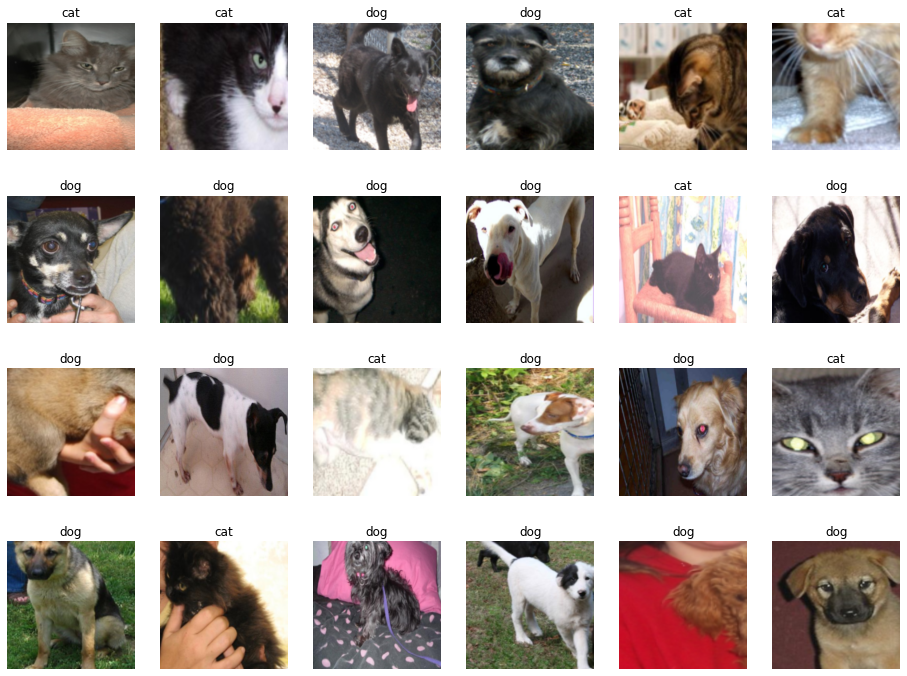

In [14]:
# 가져온 데이터를 확인을 위해 혹은 그냥 plotting 해봄.
samples, labels = iter(train_loader).next()
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [19]:
!pip3 install --upgrade certifi

In [22]:
# resnet을 불러옴. (transfer learning)
resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/yujaesang/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [23]:
# 기존 학습된 요소들은 gradient descent 를 하지 않도록 False
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(resnet18)

In [24]:
# 뒤에 우리가 cat & dog를 판단하니, 마지막 최종 layer를 만듬.
resnet18.fc = nn.Linear(512, 2)

In [25]:
# 실제 gradient descent를 하는 parameter 즉, 위에 추가된 (512,2)의 layer.
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[-0.0036, -0.0417,  0.0338,  ..., -0.0069, -0.0362,  0.0351],
        [-0.0094,  0.0078,  0.0306,  ..., -0.0139,  0.0034, -0.0078]])
fc.bias tensor([0.0261, 0.0347])


In [26]:
# 모델을 가져옴. (transfer learning)
model = models.resnet18(pretrained = True)

# 기존 parameter 는 fix
for param in model.parameters():
    param.requires_grad = False

# 최종 layer 만들고, 변하는 parameter로 세팅
model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

# 동일하게, 최적화 방법 및 cost 방법 할당
optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    #start time 기록
    since = time.time()
    
    # 분석을 위한 list
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            # 원하는 위치로 input을 넘김 (cuda or cpu)
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 원하는 위치로 input을 넘김 (cuda or cpu)
            model.to(device)
            
            # gradient -> 0 로 reset
            optimizer.zero_grad()
            # forwarding
            outputs = model(inputs)
            # loss calcuate and backwarding with optimization method
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        #loss and accuracy 기록
        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        
        # 최고의 accuracy를 저장
        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        # 기록을 해둠.
        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)        
        torch.save(model.state_dict(), os.path.join('../chap05/data/catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history

In [28]:
params_to_update = []

# 여기서 weight가 학습이 필요한 리스트를 만듬
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
        
# 이제 실제로, params_to_update 만 optimizer에 업데이트하겠다.
optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 기준은 corss entropy
criterion = nn.CrossEntropyLoss()

#위의 function으로 모델 트레이닝 시작
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.6229 Acc: 0.6442

Epoch 1/12
----------
Loss: 0.4303 Acc: 0.8208

Epoch 2/12
----------
Loss: 0.3223 Acc: 0.8909

Epoch 3/12
----------
Loss: 0.2640 Acc: 0.9143

Epoch 4/12
----------
Loss: 0.2588 Acc: 0.9143

Epoch 5/12
----------
Loss: 0.2418 Acc: 0.9221

Epoch 6/12
----------
Loss: 0.2326 Acc: 0.9065

Epoch 7/12
----------
Loss: 0.2253 Acc: 0.8961

Epoch 8/12
----------
Loss: 0.2651 Acc: 0.8909

Epoch 9/12
----------
Loss: 0.2122 Acc: 0.9221

Epoch 10/12
----------
Loss: 0.2073 Acc: 0.8987

Epoch 11/12
----------
Loss: 0.2408 Acc: 0.8987

Epoch 12/12
----------
Loss: 0.1885 Acc: 0.9299

Training complete in 18m 1s
Best Acc: 0.929870


In [30]:
# 이제 테스트를 위한 부분

# 테스트를 불러올 장소
test_path = '../chap05/data/catanddog/test'

# 불러올때, 분석에 용이하도록, 데이터를 수정해서 들어옴.
transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)

# batch size 나, 병렬 진행 등을 선택적으로 더 추가해줌
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [31]:
# 이름은 eval 모델이나, train 모델과 별 다른 것은 없음
def eval_model(model, dataloaders, device):
    # 시작점
    since = time.time()    
    acc_history = []
    best_acc = 0.0

    # 원하는 위치 (즉, 분석에 필요한 데이터)
    saved_models = glob.glob('../chap05/data/catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)
        
        # 데이터 path를 줘서 원하는 위치를 설정
        model.load_state_dict(torch.load(model_path))
        
        # model.eval()이면, weight를 학습을 하지 않고 이제 단순 분석 (loss)만 보겠다.
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            # 돌리는 현 위치를 고려해서 input을 넣어줌.
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)      
            # classification으로 기록해줌.
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels.cpu()).int().sum()
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history

In [32]:
# 위에서 학습한 것들을 돌려줌.
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['../chap05/data/catanddog/00.pth', '../chap05/data/catanddog/01.pth', '../chap05/data/catanddog/02.pth', '../chap05/data/catanddog/03.pth', '../chap05/data/catanddog/04.pth', '../chap05/data/catanddog/05.pth', '../chap05/data/catanddog/06.pth', '../chap05/data/catanddog/07.pth', '../chap05/data/catanddog/08.pth', '../chap05/data/catanddog/09.pth', '../chap05/data/catanddog/10.pth', '../chap05/data/catanddog/11.pth', '../chap05/data/catanddog/12.pth']
Loading model ../chap05/data/catanddog/00.pth
Acc: 0.8571

Loading model ../chap05/data/catanddog/01.pth
Acc: 0.9388

Loading model ../chap05/data/catanddog/02.pth
Acc: 0.9286

Loading model ../chap05/data/catanddog/03.pth
Acc: 0.9490

Loading model ../chap05/data/catanddog/04.pth
Acc: 0.9592

Loading model ../chap05/data/catanddog/05.pth
Acc: 0.9592

Loading model ../chap05/data/catanddog/06.pth
Acc: 0.9592

Loading model ../chap05/data/catanddog/07.pth
Acc: 0.9592

Loading model ../chap05/data/catanddog/08.pth
Acc: 0.9592

L

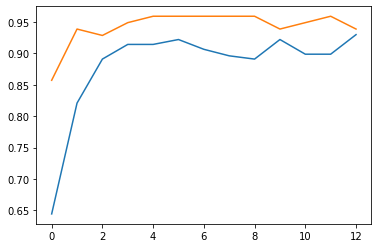

In [33]:
# 간단히 plotting (trian & test)
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

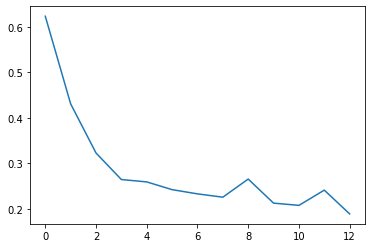

In [34]:
# train_lost 를 plotting
plt.plot(train_loss_hist)
plt.show()

In [35]:
# 이미지를 바꿔줌.
def im_convert(tensor):  
    image=tensor.clone().detach().numpy()  
    image=image.transpose(1,2,0)  
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))  
    image=image.clip(0,1)  
    return image  

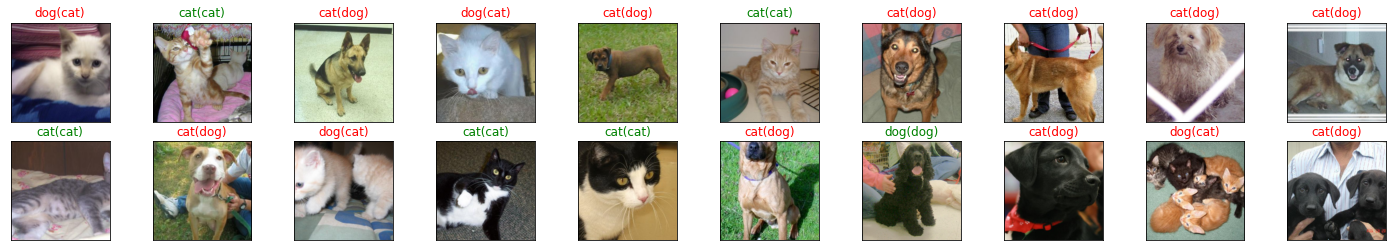

<Figure size 432x288 with 0 Axes>

In [36]:
classes = {0:'cat', 1:'dog'}

dataiter=iter(test_loader)  
images,labels=dataiter.next()  
output=model(images)  
_,preds=torch.max(output,1) 


# 이미지를 plot + 정확한 label  + 다른 label을 통해, 학습의 결과를 보여줌.
fig=plt.figure(figsize=(25,4))  
for idx in np.arange(20):  
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])  
    plt.imshow(im_convert(images[idx]))  
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))  
plt.show()  
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [1]:
# 5.4.1 특성 맵 시각화

In [38]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            #conv2d -> batchnorm ->Relu -> dropout -> conv2d -> batchnorm ->Relu -> pooling
            # 이 일련의 세트가 5개의 은닉층을 거치면서 NN이 형성
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 여디서는 이제 , 최종적으로 하나로 묶어서 판단하는 모델까지.
        # Linear -> dropout -> batchnorm -> Relu ->dropout ->linear (final activation function)
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return F.log_softmax(x)

In [41]:
model=XAI()
model.to(device)
model.eval()

# 모델을 할당 / cuda or cpu 등 맞는 조건에 모델 할당 / evaluation을 위한 용도로 변환

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

In [43]:
# class 로 만들어 layer activation을 만듬
class LayerActivations:
    features=[]
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
   
    def hook_fn(self, module, input, output):
        self.features = output.detach().numpy()
 
    def remove(self): 
        self.hook.remove()

torch.Size([1, 3, 100, 100])


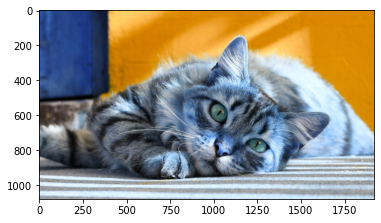

In [44]:
# 주어진 데이터를 불러와서, tensor 로 만듬
img=cv2.imread("../chap05/data/cat.jpg")   
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0)
print(img.shape)

In [45]:
# 특정 layer_nm 을 0로 하면서
result = LayerActivations(model.features, 0)

model(img)
activations = result.features

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.
/var/folders/jl/wmntyy4d25q2v0ldmswng8040000gn/T/ipykernel_61712/616206517.py:80: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


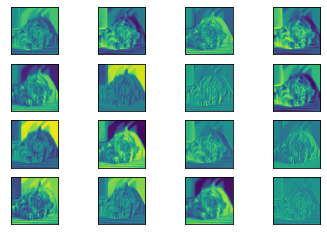

<Figure size 864x576 with 0 Axes>

In [47]:
# 조금씩 변화를 주면서, 특성 맵을 통해 설명 가능 부분을 확인
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [48]:
# 특정 layer_nm 을 20로 하면서
result = LayerActivations(model.features, 20)

model(img)
activations = result.features

/var/folders/jl/wmntyy4d25q2v0ldmswng8040000gn/T/ipykernel_61712/616206517.py:80: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


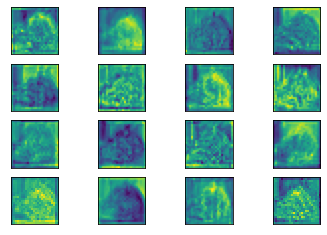

<Figure size 864x576 with 0 Axes>

In [49]:
# 조금씩 변화를 주면서, 특성 맵을 통해 설명 가능 부분을 확인
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [19]:
# 특정 layer_nm 을 40로 하면서
result = LayerActivations(model.features, 40)

model(img)
activations = result.features

<ipython-input-3-5fb1fce6f707>:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


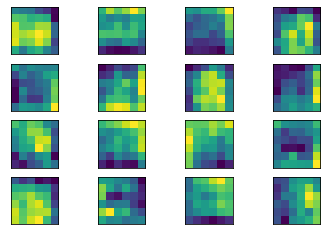

<Figure size 864x576 with 0 Axes>

In [20]:
# 조금씩 변화를 주면서, 특성 맵을 통해 설명 가능 부분을 확인
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()